In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';')

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [5]:
#The initial data contains several variables. 
#here focus on a single value : a house’s Global_active_power history, 
#that is, household global minute-averaged active power in kilowatt.

Data processing

In [6]:
#merge date, time into one variable
df['new_date'] = df['Date']+ ' ' +df['Time']
df['new_date'] = pd.to_datetime(df['new_date'])

In [7]:
df1 = df[['new_date','Global_active_power']]
df1['Global_active_power'] = pd.to_numeric(df1['Global_active_power'], errors='coerce')

In [8]:
df1= df1[df1['Global_active_power'].notnull()]

In [9]:
print('min date:', df1['new_date'].min())
print('max date:', df1['new_date'].max())

min date: 2006-12-16 17:24:00
max date: 2010-12-11 23:59:00


#### Check the Normality of the variable

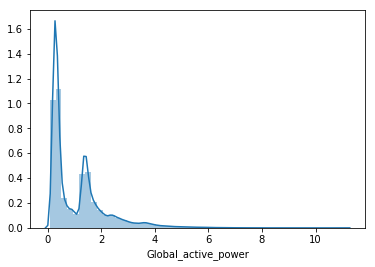

In [10]:
sb.distplot(df1['Global_active_power'])
plt.show()

In [11]:
from scipy import stats
print( 'Kurtosis : {}'.format(stats.kurtosis(df1.Global_active_power)))
print( 'Skewness : {}'.format(stats.skew(df1.Global_active_power)))

Kurtosis : 4.218671866132124
Skewness : 1.7862320846320818


In [12]:
#Kurtosis has deviated from 0
#Skewness is more than 1
#Normality has been vioalated

Normal probability plot

((array([-4.96799742, -4.79312409, -4.69871833, ...,  4.69871833,
          4.79312409,  4.96799742]),
  array([ 0.076,  0.076,  0.076, ..., 10.65 , 10.67 , 11.122])),
 (0.9473134692124322, 1.091615036500624, 0.8959769332463592))

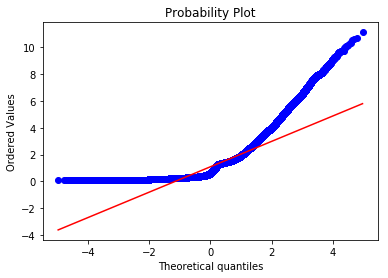

In [13]:
stats.probplot(df1['Global_active_power'],plot=plt)

In [14]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


In [15]:
#Normal probability plot also shows the data is far from normally distributed.

### Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

In [16]:
df1.set_index(df1['new_date'], inplace=True)
df2 = df1.drop('new_date', axis=1)

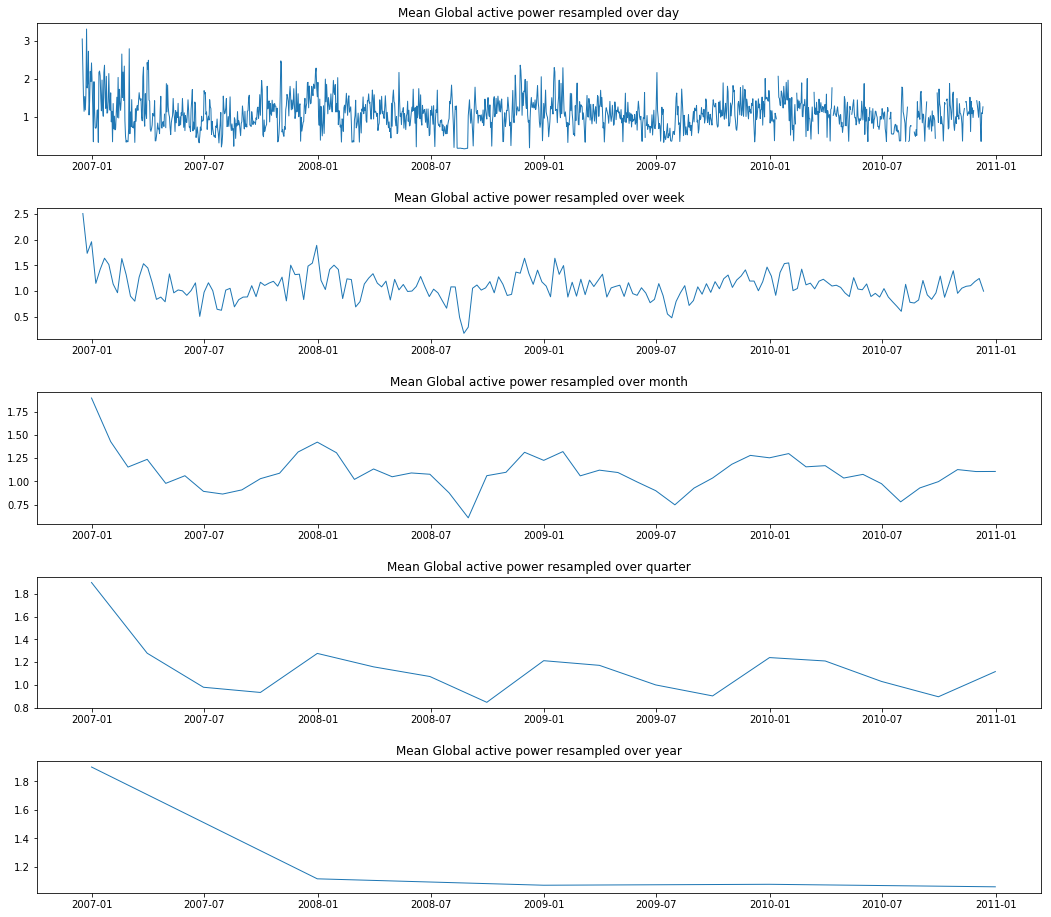

In [17]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df2['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df2['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df2['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df2['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df2['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

In [18]:
#In general, our time series does not have a upward or downward trend. 
#according to 'Mean Global active power resampled over year', highest average power consumption seems to be prior to 2007, 
#it was because we had only December data in 2006 and that month was a high consumption month. 
#if we compare year by year, it has been steady.

#### Global Active Power by Weekday vs. Weekend

In [19]:
df3 = df[['new_date','Global_active_power']]
df3['Global_active_power'] = pd.to_numeric(df1['Global_active_power'], errors='coerce')
df3= df1[df1['Global_active_power'].notnull()]

In [20]:
df3['day'] = df3['new_date'].dt.dayofweek
df3['year'] = df3['new_date'].dt.year

In [21]:
df3['weekday'] = df3['day'].apply(lambda x: 'weekday' if x<5 else 'weekend')

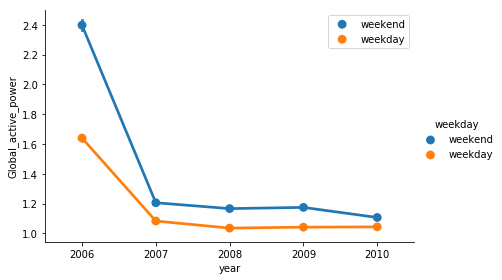

In [22]:
sb.factorplot('year','Global_active_power',hue='weekday',data=df3, size=4, aspect=1.5)   
plt.legend(loc='upper right')

#### Stationarity check - Dickey-Fuller test

In [23]:
#H0: time series is non-stationary
#H1: time series is stationary. It does not have time-dependent structure.

In [24]:
df4=df2.resample('D', how=np.mean)
df5 = df4[df4['Global_active_power'].notnull()]

#perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller test :')

dftest = adfuller(df5['Global_active_power'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test statistic','p-value','# Lags used','No of observations used'])

for key,value in dftest[4].items():
    dfoutput ['Critical value (%s)'%key] = value

print(dfoutput)
    

Results of Dickey-Fuller test :
Test statistic            -8.327686e+00
p-value                    3.435135e-13
# Lags used                9.000000e+00
No of observations used    1.423000e+03
Critical value (1%)       -3.434954e+00
Critical value (5%)       -2.863573e+00
Critical value (10%)      -2.567852e+00
dtype: float64


In [25]:
#accoding to test results we reject H0 and the time series is stationary

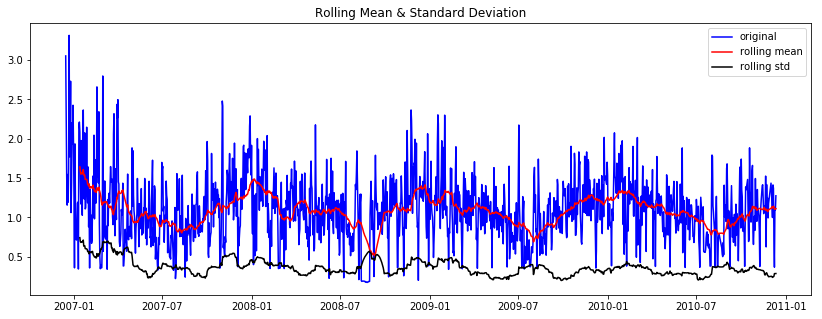

In [26]:
rolling_mean = df5.rolling(window=30).mean()
rolling_std = df5.rolling(window=30).std()

#plotting rolling statistics
plt.figure(figsize=(14,5))
plt.plot(df5,color='blue', label='original')
plt.plot(rolling_mean,color='red', label='rolling mean')
plt.plot(rolling_std,color='black', label='rolling std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

### Fitting LSTM

using a multi-layered LSTM recurrent neural network to predict the last sequence of values.

#### pre-processing for LSTM model:

resample minutes data into 1/2 hours

prediction frequency : 2 hours predicts -> next 2 hours (step size=4 time steps in 1/2 hours)

In [82]:
dfx= df2.resample('30min').sum()
dfx.head()

,Global_active_power
new_date,
2006-12-16 17:00:00,27.524
2006-12-16 17:30:00,124.500
2006-12-16 18:00:00,118.344
2006-12-16 18:30:00,99.588
2006-12-16 19:00:00,103.932


In [83]:
#Split into training and test sets
train = dfx['2006-12-16':'2009-12-31']
test = dfx['2009-12-31':]

In [84]:
print('train-shape:', train.shape)
print('test-shape:', test.shape)

train-shape: (53342, 1)
test-shape: (16608, 1)


In [85]:
#convert into array
train = np.array(train)

In [86]:
#Reshape into X=t and Y=t+1, t=4
X_train, y_train = [], []

for i in range(4,len(train)-4):
    X_train.append(train[i-4:i])
    y_train.append(train[i:i+4])

In [87]:
#convert X_train, y_train into numpy arrays

X_train, y_train = np.array(X_train), np.array(y_train)

In [88]:
X_train.shape, y_train.shape

((53334, 4, 1), (53334, 4, 1))

In [89]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1])
y_train = y_train.reshape(X_train.shape[0],X_train.shape[1])

In [90]:
pd.DataFrame(X_train).head()

,0,1,2,3
0,27.524,124.500,118.344,99.588
1,124.500,118.344,99.588,103.932
2,118.344,99.588,103.932,100.082
3,99.588,103.932,100.082,98.958
4,103.932,100.082,98.958,97.156


In [91]:
pd.DataFrame(y_train).head()

,0,1,2,3
0,103.932,100.082,98.958,97.156
1,100.082,98.958,97.156,90.970
2,98.958,97.156,90.970,92.418
3,97.156,90.970,92.418,75.468
4,90.970,92.418,75.468,56.540


In [92]:
#applying scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

In [93]:
# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_train.shape

(53334, 4, 1)

#### Model Architecture

Define the LSTM with 200 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. 

In [57]:
#Dropout 20%
#Use the MSE loss function and the efficient Adam version of stochastic gradient descent
#The model will be fit for 50 training epochs with a batch size of 70

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [94]:
model = Sequential()
model.add(LSTM(units=200, activation='relu', input_shape=(4,1))) #input_shape=(time step, features)
model.add(Dropout(0.2))
model.add(Dense(4)) #multi-step, predicting 24 steps (Hrs) ahead in the future

In [95]:
model.compile(loss='mse', optimizer='adam')

In [96]:
model.fit(X_train, y_train, epochs=20,batch_size=70)

Train on 53334 samples
Epoch 1/20
53334/53334 [==============================] - 9s 160us/sample - loss: 0.0110
Epoch 2/20
53334/53334 [==============================] - 7s 137us/sample - loss: 0.0100
Epoch 3/20
53334/53334 [==============================] - 7s 137us/sample - loss: 0.0099
Epoch 4/20
53334/53334 [==============================] - 7s 137us/sample - loss: 0.0098
Epoch 5/20
53334/53334 [==============================] - 7s 136us/sample - loss: 0.0098
Epoch 6/20
53334/53334 [==============================] - 7s 138us/sample - loss: 0.0098
Epoch 7/20
53334/53334 [==============================] - 7s 140us/sample - loss: 0.0098
Epoch 8/20
53334/53334 [==============================] - 7s 140us/sample - loss: 0.0098
Epoch 9/20
53334/53334 [==============================] - 7s 138us/sample - loss: 0.0098
Epoch 10/20
53334/53334 [==============================] - 8s 143us/sample - loss: 0.0098
Epoch 11/20
53334/53334 [==============================] - 8s 144us/sample - loss: 0.0

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________


Preparing test dataset

In [98]:
test = np.array(test)

In [99]:
X_test, y_test = [], []

for i in range(4,len(test)-4):
    X_test.append(test[i-4:i])
    y_test.append(test[i:i+4])

In [100]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((16600, 4, 1), (16600, 4, 1))

In [101]:
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])

In [102]:
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

In [103]:
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Predictions

In [104]:
y_pred = model.predict(X_test)

In [105]:
y_pred = scaler.inverse_transform(y_pred)
y_act = scaler.inverse_transform(y_test)

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [107]:
print('Test Mean Absolute Error:', mean_absolute_error(y_act[0], y_pred[0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_act[0], y_pred[0])))

Test Mean Absolute Error: 7.899734060287475
Test Root Mean Squared Error: 8.697808937931056


#### Actual vs. Prediction

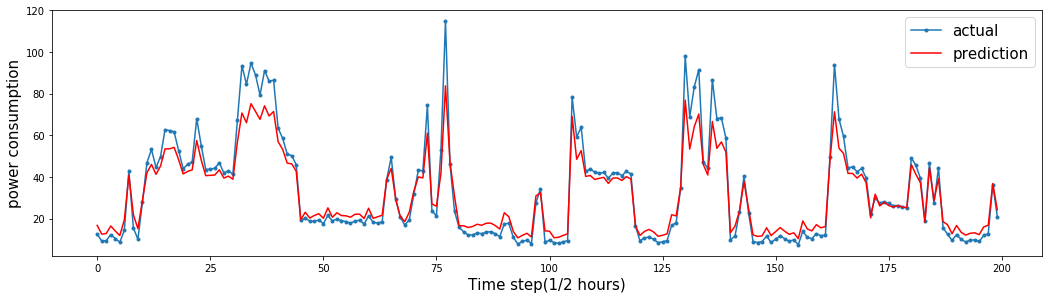

In [109]:
x_range=[x for x in range(200)]
plt.figure(figsize=(15,4))
plt.plot(x_range, y_act[:200,0], marker='.', label="actual")
plt.plot(x_range, y_pred[1:201,0], 'r', label="prediction")


plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('power consumption', size=15)
plt.xlabel('Time step(1/2 hours)', size=15)
plt.legend(fontsize=15)
plt.show();

predictions seems very close to actual pattern; 
LSTM is a powerful method to predict time series in comparison with conventional methods